In [103]:
# !pip install opendatasets
# import opendatasets as od
# od.download("https://www.kaggle.com/competitions/cpe-ai-openhouse-loan-approval-prediction/overview")

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [105]:
train = pd.read_csv('/content/cpe-ai-openhouse-loan-approval-prediction/Loan Approval Prediction Data/train.csv')
final = pd.read_csv('/content/cpe-ai-openhouse-loan-approval-prediction/Loan Approval Prediction Data/test.csv')

train = train.drop(columns=['id'])
id_final = final.id
final = final.drop(columns=['id'])

In [106]:
def preparation(df):
  df = df.rename(columns={
      'person_age' : 'age',
      'person_income' : 'income',
      'person_home_ownership' : 'home',
      'person_emp_length' : 'emp',
      'loan_intent' : 'intent',
      'loan_grade' : 'gra',
      'loan_amnt' : 'amnt',
      'loan_int_rate' : 'rate',
      'loan_percent_income' : 'percome',
      'cb_person_default_on_file' : 'file',
      'cb_person_cred_hist_length' : 'cred',
      'loan_status' : 'status'
  })
  df = pd.get_dummies(df, columns=['home', 'intent', 'gra', 'file'], dtype=int)
  df = df.fillna(df.median())
  return df

train = preparation(train)
final = preparation(final)

<Axes: >

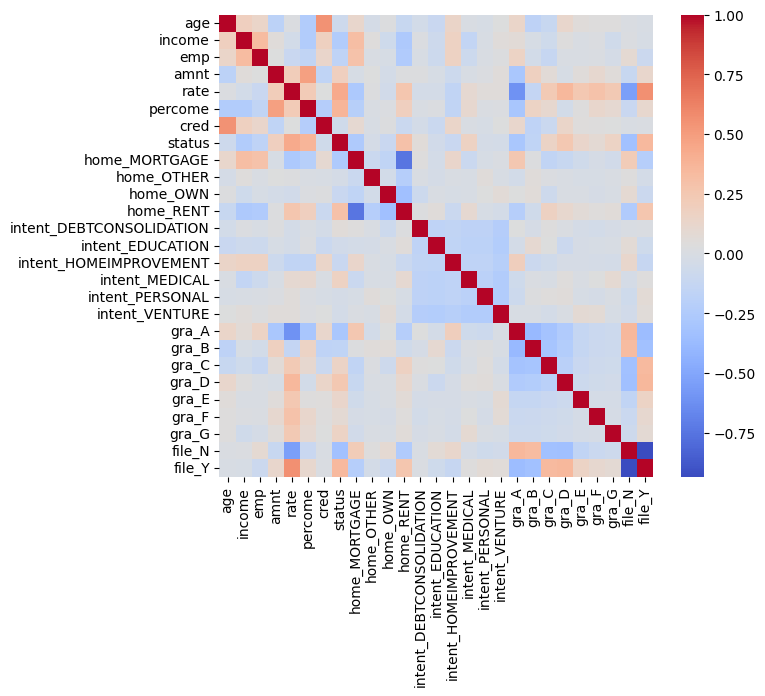

In [107]:
cor = train.corr()
plt.figure(figsize=(7,6))
sns.heatmap(cor, annot=False, cmap='coolwarm')

In [108]:
x = train.iloc[:10000, :-1]
y = train.iloc[:10000, -1]
norm_x = StandardScaler().fit_transform(x)
norm_final = StandardScaler().fit_transform(final)
x = pd.DataFrame(norm_x, columns=x.columns)
final = pd.DataFrame(norm_final, columns=final.columns)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [109]:
x = x.to_numpy()
y = y.to_numpy()
y = (y*2)-1

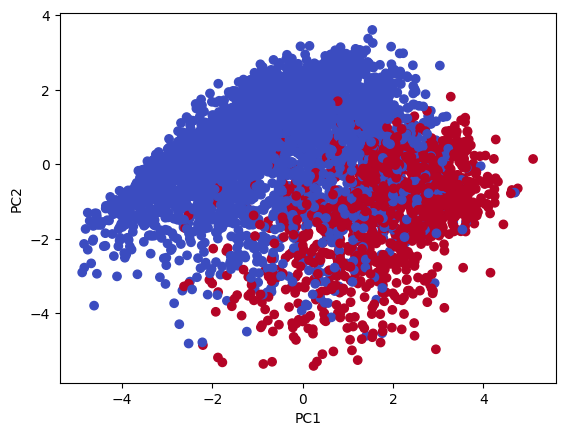

In [110]:
from sklearn.decomposition import PCA
x_re = PCA(n_components=2).fit_transform(x)

plt.scatter(x_re[:, 0], x_re[:, 1], c=y, cmap='coolwarm')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [111]:
def Kernel(x1, x2, gamma):
  return torch.exp( -(gamma) * (torch.norm(x1-x2)**2) )

def Gram_Matrix(x, gamma):
  n = x.shape[0]
  gram = torch.zeros((n, n))
  for i in range(n):
    if i % 100 == 0:
      print(f"Computing row {i+100}/{n}")
    for j in range(n):
      gram[i, j] = Kernel(x[i], x[j], gamma)
  return gram

def Alpha(x, y, gamma):
  return torch.pinverse( (Gram_Matrix(x, gamma)) + (torch.eye(len(y))*0.1) ) @ y

def RBF_SVM(x_train, y_train, x_val, alpha, gamma):
  y_hat = []
  for index, x in enumerate(x_val):
    temp = 0
    for ai, yi, xi in zip(alpha, y_train, x_train):
      temp += (ai * yi) * Kernel(xi, x, gamma)
    y_hat.append(torch.sign(temp))
    if index % 100 == 0:
      print(f"Predicted {index+100}/{x_val.shape[0]} samples")
  return torch.stack(y_hat)

In [112]:
x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_val = torch.tensor(x_val.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

gamma = 1
alpha = Alpha(x_train, y_train, gamma)
y_hat = RBF_SVM(x_train, y_train, x_val, alpha, gamma)

acc = (y_hat == y_val).float().mean()
print(f"Accuracy: {acc.item()}")

Computing row 100/4000
Computing row 200/4000
Computing row 300/4000
Computing row 400/4000
Computing row 500/4000
Computing row 600/4000
Computing row 700/4000
Computing row 800/4000
Computing row 900/4000
Computing row 1000/4000
Computing row 1100/4000
Computing row 1200/4000
Computing row 1300/4000
Computing row 1400/4000
Computing row 1500/4000
Computing row 1600/4000
Computing row 1700/4000
Computing row 1800/4000
Computing row 1900/4000
Computing row 2000/4000
Computing row 2100/4000
Computing row 2200/4000
Computing row 2300/4000
Computing row 2400/4000
Computing row 2500/4000
Computing row 2600/4000
Computing row 2700/4000
Computing row 2800/4000
Computing row 2900/4000
Computing row 3000/4000
Computing row 3100/4000
Computing row 3200/4000
Computing row 3300/4000
Computing row 3400/4000
Computing row 3500/4000
Computing row 3600/4000
Computing row 3700/4000
Computing row 3800/4000
Computing row 3900/4000
Computing row 4000/4000
Predicted 100/1000 samples
Predicted 200/1000 sam

In [113]:
x_final = torch.tensor(final.values, dtype=torch.float32)
y_hat_final = RBF_SVM(x_train, y_train, x_final, alpha, gamma)
y_hat_final = (y_hat_final > 0).int()

y_hat = pd.DataFrame(y_hat_final)
summarize = pd.concat([id_final, y_hat], axis=1)
summarize.columns = ['id', 'loan_status']
summarize.to_csv('My_Answer.csv', index=False)
print(summarize['loan_status'].unique())
summarize

Predicted 100/7910 samples
Predicted 200/7910 samples
Predicted 300/7910 samples
Predicted 400/7910 samples
Predicted 500/7910 samples
Predicted 600/7910 samples
Predicted 700/7910 samples
Predicted 800/7910 samples
Predicted 900/7910 samples
Predicted 1000/7910 samples
Predicted 1100/7910 samples
Predicted 1200/7910 samples
Predicted 1300/7910 samples
Predicted 1400/7910 samples
Predicted 1500/7910 samples
Predicted 1600/7910 samples
Predicted 1700/7910 samples
Predicted 1800/7910 samples
Predicted 1900/7910 samples
Predicted 2000/7910 samples
Predicted 2100/7910 samples
Predicted 2200/7910 samples
Predicted 2300/7910 samples
Predicted 2400/7910 samples
Predicted 2500/7910 samples
Predicted 2600/7910 samples
Predicted 2700/7910 samples
Predicted 2800/7910 samples
Predicted 2900/7910 samples
Predicted 3000/7910 samples
Predicted 3100/7910 samples
Predicted 3200/7910 samples
Predicted 3300/7910 samples
Predicted 3400/7910 samples
Predicted 3500/7910 samples
Predicted 3600/7910 samples
P

,id,loan_status
0,31641,1
1,31642,1
2,31643,1
3,31644,1
4,31645,1
...,...,...
7905,39546,1
7906,39547,1
7907,39548,1
7908,39549,1
